## DOWNLOAD DATA FROM SENTINEL

In [1]:
from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    MimeType,
    MosaickingOrder,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# sentinel hub user credential
config = SHConfig()
config.sh_client_id = "e43faa9d-da0c-41c6-b8cc-20ca963c9d36"
config.sh_client_secret = ":?1&ZxLq2T&m_8U&3>^(YfL,j{SGj3-U4e{z5x?L"

evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04", "B08"]
            }],
            output: {
                bands: 4
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02, sample.B03, sample.B04, sample.B08];
    }
"""

for location in [
    ("presila", (16.279444, 39.31, 16.325556, 39.336944)),
    ("lorica", (16.430278, 39.2075, 16.564444, 39.271944))
]:
    
    bbox = BBox(bbox=location[1], crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution=5)

    for season in [
        ("./data/" + location[0] + "/02_feb", ("2022-02-01", "2022-02-28")),
        ("./data/" + location[0] + "/05_may", ("2022-05-01", "2022-05-31")),
        ("./data/" + location[0] + "/08_aug", ("2022-08-01", "2022-08-31")),
        ("./data/" + location[0] + "/11_nov", ("2022-11-01", "2022-11-30"))
    ]:
        
        request = SentinelHubRequest(
            config=config,
            bbox=bbox,
            size=size,
            evalscript=evalscript,
            data_folder=season[0],
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=season[1],
                    mosaicking_order=MosaickingOrder.LEAST_CC
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        )

        images = request.get_data(save_data=True)

## USING RASTERIO TO OPEN THE DOWLOADED GEOTIFF DATA AND NDVI CALCUTATION

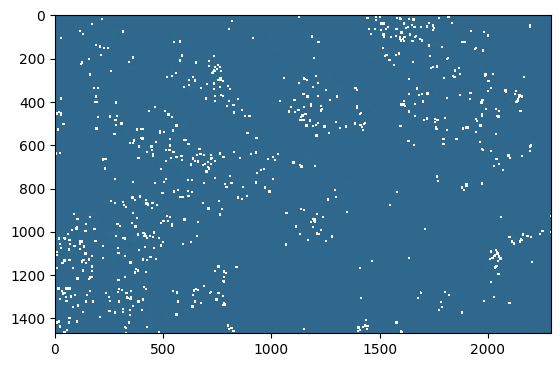

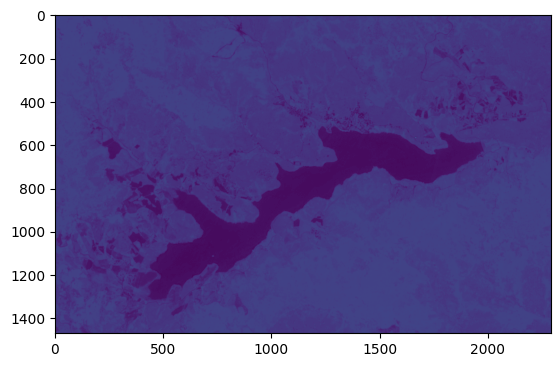

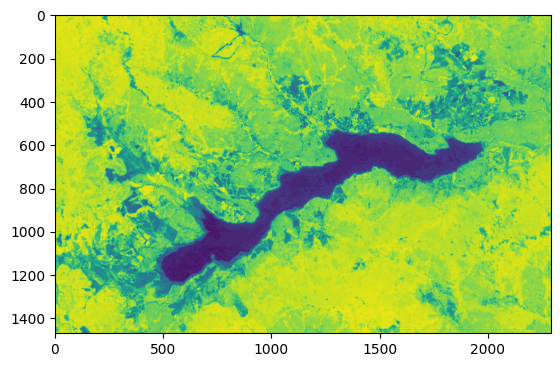

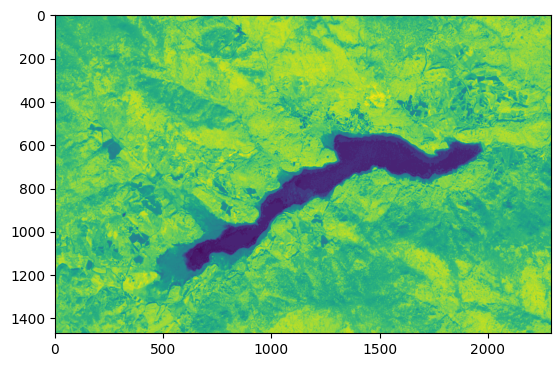

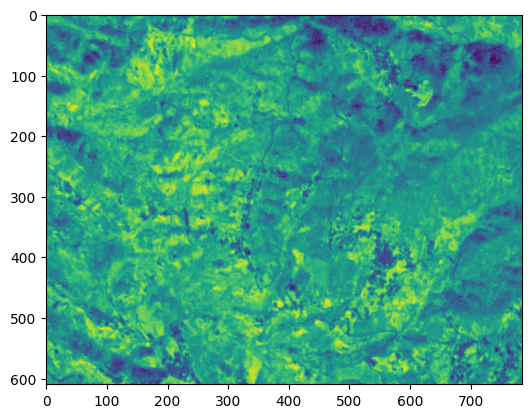

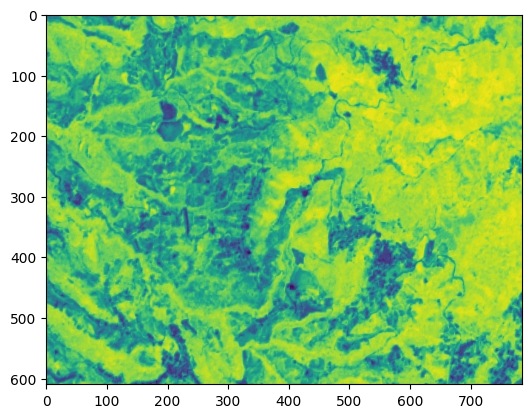

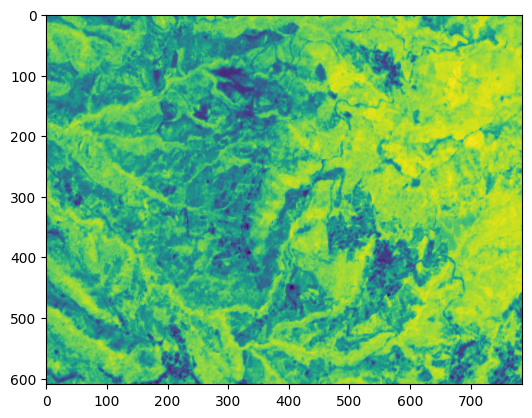

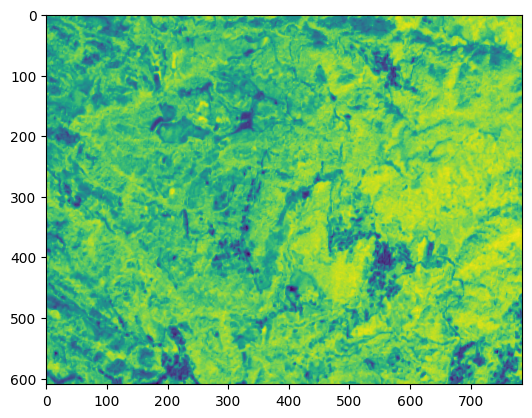

In [4]:
import os

import rasterio
import rasterio.features
import rasterio.warp

from rasterio.plot import show

import numpy

# Allow division by zero
numpy.seterr(divide='ignore', invalid='ignore')

for location in os.listdir("./data"):
    for season in os.listdir("./data/" + location):
        dataset = rasterio.open("./data/" + location + "/" + season + "/" + os.listdir("./data/" + location + "/" + season)[0] + "/response.TIFF")
    
        band_red = dataset.read(3)
        band_nir = dataset.read(4)
        ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)
        show(ndvi)

        dataset.close()

